In [1]:
# import required packages
import os
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision
from torchvision import transforms, datasets
import numpy as np
import warnings
from vgg_sym import *

warnings.filterwarnings('ignore')

In [2]:
# Utility functions
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', round(os.path.getsize('temp.p')/(1024*1024),3))
    os.remove('temp.p')
    

# Routines for Quantization    
    
from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
nb = 8
def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, num_bits=nb, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale_next = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale_next
  
  zero_point_next = 0
  if initial_zero_point < qmin:
      zero_point_next = qmin
  elif initial_zero_point > qmax:
      zero_point_next = qmax
  else:
      zero_point_next = initial_zero_point

  zero_point_next = int(zero_point_next)

  return scale_next, zero_point_next
  
def quantizeLayer(x, layer, stat, scale_x, zp_x, num_bits=nb):
  # for both conv and linear layers
  W = layer.weight.data
  B = layer.bias.data

  # scale_x = x.scale
  # zp_x = x.zero_point
  w = quantize_tensor(layer.weight.data,num_bits) 
  b = quantize_tensor(layer.bias.data,num_bits)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ####################################################################
  # This is Quantisation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  scale_w = w.scale
  zp_w = w.zero_point
  
  scale_b = b.scale
  zp_b = b.zero_point
  

  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Perparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = (scale_x * scale_w/scale_next)*(layer.weight.data - zp_w)
  layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int

  #x = (layer(X)/ scale_next) + zero_point_next 
  x = layer(X) + zero_point_next   
  
  # Perform relu too
  x = F.relu(x)
    
    
  # Reset
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next


def quantForward(model, x, stats):
  #print(x.shape)
  # Quantise before inputting into incoming layers
  x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'])
  #print(model.features[0].weight.data.shape)

  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.features[0], stats['conv2'], x.scale, x.zero_point)
  #x = model.features[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[2], stats['conv3'], scale_next, zero_point_next)
  #x = model.features[3](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[4], stats['conv4'], scale_next, zero_point_next)
  #x = model.features[5](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[6], stats['conv5'], scale_next, zero_point_next)
  #x = model.features[7](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[8], stats['conv6'], scale_next, zero_point_next)
  #x = model.features[9](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[10], stats['conv7'], scale_next, zero_point_next)
  #x = model.features[11](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[12], stats['conv8'], scale_next, zero_point_next)
  #x = model.features[13](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[14], stats['fc'], scale_next, zero_point_next)
  #x = model.features[15](x)
    
  
  #x = x.view(x.size(0), -1)  
  x = x.view(-1, 512)   
  
  
  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
   
  x = model.classifier(x)

  return x


# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)
  
  
  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  x = model.features[1](model.features[0](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
  x =  model.features[3](model.features[2](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3')
  x = model.features[5](model.features[4](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4')
  x = model.features[7](model.features[6](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5')
  x = model.features[9](model.features[8](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6')
  x = model.features[11](model.features[10](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7')
  x = model.features[13](model.features[12](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8')
  x = model.features[15](model.features[14](x))

  #x = x.view(x.size(0), -1)  
  x = x.view(-1, 512) 
  
  stats = updateStats(x, stats, 'fc')

  x = model.classifier(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"] }
    return final_stats

# Routines for performance testing

def test(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False, stats=None):
    model.to(device)
    model.eval()
    
    print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            #st = time.time()
            # Testing with qauntization if quantize=True
            if quantize:
                output = quantForward(model, X, stats)
            else:    
                output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 2)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

    
    
# Routines related to pruning     

def check_sparsity(model):
    print(
        "Sparsity in conv1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[0].weight == 0))
            / float(model.features[0].weight.nelement())
        )
    )
    print(
        "Sparsity in conv2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[2].weight == 0))
            / float(model.features[2].weight.nelement())
        )
    )
    print(
        "Sparsity in conv3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[4].weight == 0))
            / float(model.features[4].weight.nelement())
        )
    )
    print(
        "Sparsity in conv4.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[6].weight == 0))
            / float(model.features[6].weight.nelement())
        )
    )
    print(
        "Sparsity in conv5.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[8].weight == 0))
            / float(model.features[8].weight.nelement())
        )
    )
    print(
        "Sparsity in conv6.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[10].weight == 0))
            / float(model.features[10].weight.nelement())
        )
    )
    print(
        "Sparsity in conv7.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[12].weight == 0))
            / float(model.features[12].weight.nelement())
        )
    )
    print(
        "Sparsity in conv8.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[14].weight == 0))
            / float(model.features[14].weight.nelement())
        )
    )
    print(
        "Sparsity in fc1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.classifier[0].weight == 0))
            / float(model.classifier[0].weight.nelement())
        )
    )
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(model.features[0].weight == 0)
                + torch.sum(model.features[2].weight == 0)
                + torch.sum(model.features[4].weight == 0)
                + torch.sum(model.features[6].weight == 0)
                + torch.sum(model.features[8].weight == 0)
                + torch.sum(model.features[10].weight == 0)
                + torch.sum(model.features[12].weight == 0)
                + torch.sum(model.features[14].weight == 0)
                + torch.sum(model.classifier[0].weight == 0)
            )
            / float(
                model.features[0].weight.nelement()
                + model.features[2].weight.nelement()
                + model.features[4].weight.nelement()
                + model.features[6].weight.nelement()
                + model.features[8].weight.nelement()
                + model.features[10].weight.nelement()
                + model.features[12].weight.nelement()
                + model.features[14].weight.nelement()
                + model.classifier[0].weight.nelement()
            )
        )
    )
    
    
def check_sparsity_unst(model):
    print(
        "Sparsity in conv1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[0].weight == 0))
            / float(model.features[0].weight.nelement())
        )
    )
    print(
        "Sparsity in conv2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[2].weight == 0))
            / float(model.features[2].weight.nelement())
        )
    )
    print(
        "Sparsity in conv3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[4].weight == 0))
            / float(model.features[4].weight.nelement())
        )
    )
    print(
        "Sparsity in conv4.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[6].weight == 0))
            / float(model.features[6].weight.nelement())
        )
    )
    print(
        "Sparsity in conv5.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[8].weight == 0))
            / float(model.features[8].weight.nelement())
        )
    )
    print(
        "Sparsity in conv6.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[10].weight == 0))
            / float(model.features[10].weight.nelement())
        )
    )
    print(
        "Sparsity in conv7.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[12].weight == 0))
            / float(model.features[12].weight.nelement())
        )
    )
    print(
        "Sparsity in conv8.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[14].weight == 0))
            / float(model.features[14].weight.nelement())
        )
    )
    print(
        "Sparsity in fc1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.classifier.weight == 0))
            / float(model.classifier.weight.nelement())
        )
    )
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(model.features[0].weight == 0)
                + torch.sum(model.features[2].weight == 0)
                + torch.sum(model.features[4].weight == 0)
                + torch.sum(model.features[6].weight == 0)
                + torch.sum(model.features[8].weight == 0)
                + torch.sum(model.features[10].weight == 0)
                + torch.sum(model.features[12].weight == 0)
                + torch.sum(model.features[14].weight == 0)
                + torch.sum(model.classifier.weight == 0)
            )
            / float(
                model.features[0].weight.nelement()
                + model.features[2].weight.nelement()
                + model.features[4].weight.nelement()
                + model.features[6].weight.nelement()
                + model.features[8].weight.nelement()
                + model.features[10].weight.nelement()
                + model.features[12].weight.nelement()
                + model.features[14].weight.nelement()
                + model.classifier.weight.nelement()
            )
        )
    )
    
# Use this knowledge to prune the network locally
def local_prune_and_test(sp, net, structured=True, quantize=True, stats=None):
    # prune the model layerwise
    prune.l1_unstructured(net.features[0], name="weight", amount=sp[0])
    prune.l1_unstructured(net.features[2], name="weight", amount=sp[1])
    prune.l1_unstructured(net.features[4], name="weight", amount=sp[2])
    prune.l1_unstructured(net.features[6], name="weight", amount=sp[3])
    prune.l1_unstructured(net.features[8], name="weight", amount=sp[4])
    prune.l1_unstructured(net.features[10], name="weight", amount=sp[5])
    prune.l1_unstructured(net.features[12], name="weight", amount=sp[6])
    prune.l1_unstructured(net.features[14], name="weight", amount=sp[7])
    prune.l1_unstructured(net.classifier[0], name="weight", amount=sp[8])

    # Remove the layerwise data structures for pruning
    net.features[0] = prune.remove(net.features[0], name='weight')
    net.features[2] = prune.remove(net.features[2], name='weight')
    net.features[4] = prune.remove(net.features[4], name='weight')
    net.features[6] = prune.remove(net.features[6], name='weight')
    net.features[8] = prune.remove(net.features[8], name='weight')
    net.features[10] = prune.remove(net.features[10], name='weight')
    net.features[12] = prune.remove(net.features[12], name='weight')
    net.features[14] = prune.remove(net.features[14], name='weight')
    net.classifier = prune.remove(net.classifier[0], name='weight')

    # Check sparsity
    if structured:
        check_sparsity(net)
    else:
        check_sparsity_unst(net)

    # test the baseline accuracy this is a trial & error phase
    test(model=net, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=quantize, stats=stats)

torch.Size([16, 3, 32, 32])
torch.Size([16])


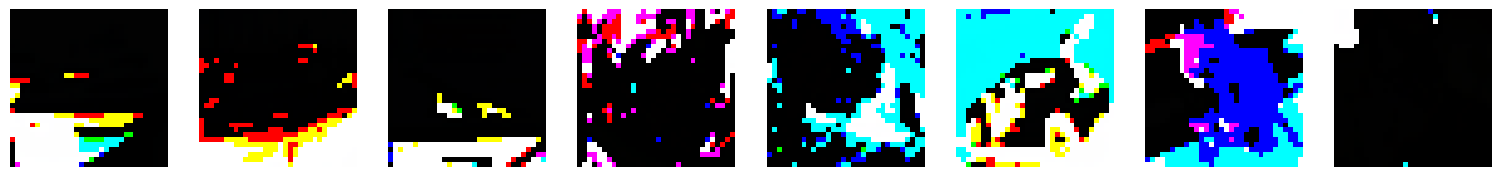

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
bs= 16 
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='../../../formal_pruning/dataset', train=True, download=False, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='../../../formal_pruning/dataset', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images, labels = next(iter(testloader))

print(images.shape)
print(labels.shape)

figure = plt.figure(figsize = (24,16))
num_of_images = 8
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1,2,0).numpy().squeeze().astype('uint8'), cmap='cool')

In [4]:
# Load the model
pretrained_model = "./cifar_vgg_sym_v3.pt"
net = VGG('VGG11')
sd = torch.load(pretrained_model, map_location=torch.device('cpu'))
net.load_state_dict(sd['net'])

<All keys matched successfully>

In [5]:
# Baseline performance - unquantized model
device = 'cpu'
test(model=net, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 35.198
PyTorch optimized model te

In [7]:
# Quantized model performance
import copy
netq = copy.deepcopy(net)

# one time stats gathering - we will keep this stored for CIFAR for the FPGA implementation
#stats = gatherStats(netq, trainloader)
stats = gatherStats(netq, testloader)
print(stats)

{'conv1': {'max': tensor(38.0929), 'min': tensor(-34.3413)}, 'conv2': {'max': tensor(102.6974), 'min': tensor(0.)}, 'conv3': {'max': tensor(106.0568), 'min': tensor(0.)}, 'conv4': {'max': tensor(71.1720), 'min': tensor(0.)}, 'conv5': {'max': tensor(50.4030), 'min': tensor(0.)}, 'conv6': {'max': tensor(23.9288), 'min': tensor(0.)}, 'conv7': {'max': tensor(15.2678), 'min': tensor(0.)}, 'conv8': {'max': tensor(33.0083), 'min': tensor(0.)}, 'fc': {'max': tensor(61.2125), 'min': tensor(0.)}}


In [8]:
# Quantized Inference with the normal model
test(model=netq, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True, stats=stats)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 35.198
PyTorch optimized model te

In [ ]:
# Load the QAT trained model
pretrained_modelqat = "./cifar_qat.pt"
netqat = VGG('VGG11')
sdqat = torch.load(pretrained_modelqat, map_location=torch.device('cpu'))
netqat.load_state_dict(sdqat['net'])

In [ ]:
# Gathering stats for activation quantization
stats = gatherStats(netqat, testloader)
print(stats)
device = 'cpu'
# Try inferencing
#test(model=netqat, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True, stats=stats)
test_qat(model=netqat, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True, stats=stats)